In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


TypeError: ignored

In [14]:
# Define paths to the train directory
train_dir = '/content/drive/MyDrive/AlzheimerDataset/train'

# Define hyperparameters for image preprocessing
image_width = 176
image_height = 208
batch_size = 32

# Create an ImageDataGenerator for train set
train_datagen = ImageDataGenerator(rescale=1./255)

# Create image generator for train set
# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     validation_split = 0.2,
#     subset = 0.2,
#     target_size=(image_width, image_height),
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False  # Disabling shuffle to preserve the order of images
# )
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)



Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
from tensorflow.keras import layers

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [24]:
from tensorflow.keras.models import Sequential
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 208, 176, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 208, 176, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 104, 88, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 104, 88, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 52, 44, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 44, 64)        1

In [27]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
129/129 [==============================] - 326s 3s/step - loss: 0.9960 - accuracy: 0.5253 - val_loss: 0.8644 - val_accuracy: 0.5732
Epoch 2/10
129/129 [==============================] - 193s 1s/step - loss: 0.7636 - accuracy: 0.6544 - val_loss: 0.6349 - val_accuracy: 0.7305
Epoch 3/10
129/129 [==============================] - 195s 2s/step - loss: 0.4729 - accuracy: 0.8064 - val_loss: 0.3331 - val_accuracy: 0.8652
Epoch 4/10
129/129 [==============================] - 193s 1s/step - loss: 0.2458 - accuracy: 0.9055 - val_loss: 0.2177 - val_accuracy: 0.9229
Epoch 5/10
129/129 [==============================] - 201s 2s/step - loss: 0.0956 - accuracy: 0.9678 - val_loss: 0.1171 - val_accuracy: 0.9639
Epoch 6/10
129/129 [==============================] - 202s 2s/step - loss: 0.0531 - accuracy: 0.9827 - val_loss: 0.1235 - val_accuracy: 0.9590
Epoch 7/10
129/129 [==============================] - 195s 2s/step - loss: 0.0116 - accuracy: 0.9968 - val_loss: 0.0705 - val_accuracy: 0.9736

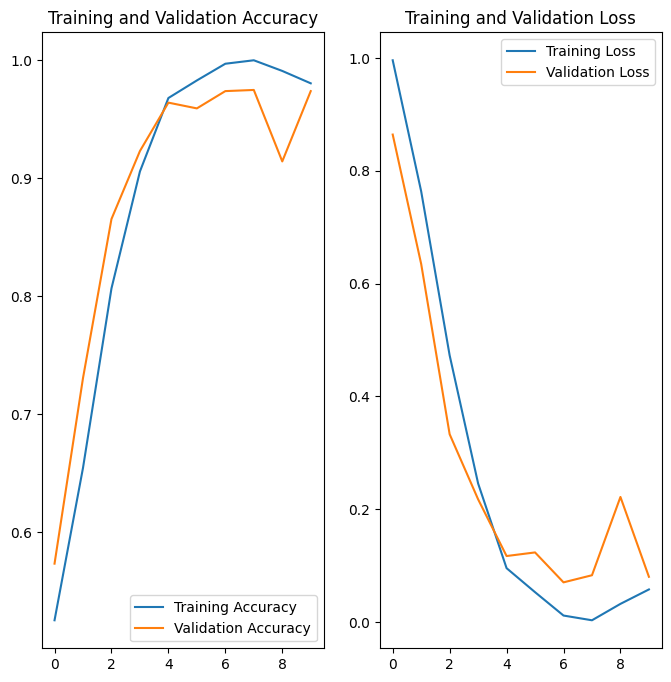

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
test_path_dir = '/content/drive/MyDrive/NORMBRAIN.jpg'
img = tf.keras.utils.load_img(
    test_path_dir, target_size=(image_height, image_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 41ms/step
This image most likely belongs to NonDemented with a 100.00 percent confidence.


In [44]:
model.save('AlzheimerModel.keras')